### **Importing Relevant Python Packages**

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

pd.set_option('display.max_columns', None)
import sklearn.metrics as metrics
import sklearn.model_selection as mdl
from sklearn.linear_model import LogisticRegression
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor, plot_importance

### **Examining and Cleaning HR Dataset**

In [ ]:
df = pd.read_csv("HR_capstone_dataset.csv")
df.head()

In [ ]:
df.describe()

In [15]:
df.info()
# Clean the data titles by correcting typos and converting all column names into snake case.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [16]:
df = df.rename(columns = {"average_montly_hours": "average_monthly_hours", 
                        "time_spend_company": "tenure",
                        "Work_accident": "work_accident",
                        "Department": "department"})
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [17]:
df.isna().sum()
# No missing data.

satisfaction_level       0
last_evaluation          0
number_project           0
average_monthly_hours    0
tenure                   0
work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

In [19]:
df.duplicated().sum()
# However, there are 3008 duplicate data. Hence we should drop these repeat values.

3008

In [20]:
df = df.drop_duplicates(keep = "first")

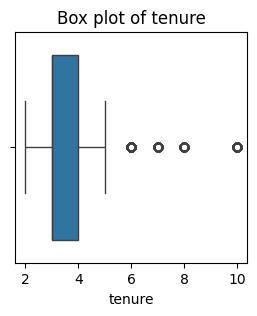

In [23]:
plt.figure(figsize = (3, 3))
sns.boxplot(x = df["tenure"])
plt.title("Box plot of tenure")
plt.show()
# From the boxplot, we see that there are outliers in the data.

In [ ]:
percen25 = df["tenure"].quantile(0.25)
percen75 = df["tenure"].quantile(0.75)
iqr = percen75-percen25
upper = percen75 + 1.5*iqr
lower = percen25 - 1.5*iqr
outliers = df[(df["tenure"]>upper) | (df["tenure"]<lower)]
outliers
# There are 824 rows of data with outlying tenure values. 

In [26]:
df["left"].value_counts()
# 10000 employees stayed, while 1991 left.

left
0    10000
1     1991
Name: count, dtype: int64

### **Analysing Variables and Their Relationships**

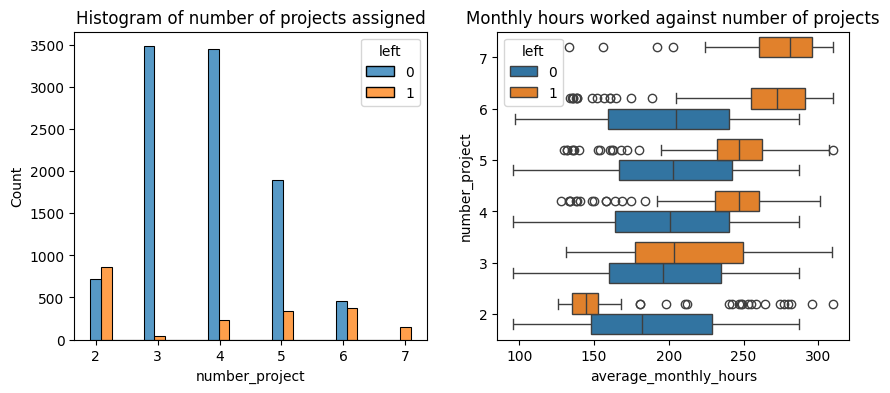

In [35]:
# Comparing distribution of employees who stayed/left depending on the number of projects assigned, 
# and number of hours worked against number of projects.
fig, ax = plt.subplots(1, 2, figsize = (10,4))
sns.histplot(data = df, x = "number_project", hue = "left", multiple = "dodge", shrink = 2, ax = ax[0])
ax[0].set_title("Histogram of number of projects assigned")

sns.boxplot(data = df, x = "average_monthly_hours", y = "number_project", hue = "left", orient = "h",
            ax = ax[1])
ax[1].set_title("Monthly hours worked against number of projects")
ax[1].invert_yaxis()

plt.show()

Employees who had more projects assigned also worked longer hours. This can be seen in the boxplot as mean hours worked increases as number of projects increases.

There are generally 2 groups of people who left the company. Those who worked less with the same number of projects (2 projects), and those who worked more (7 projects). As observed from the histogram, all employees with 7 projects left. From the boxplot, average monthly hours worked for the employees who left is around 250h and above. Hence they were likely to be overworked. The optimal number of projects seem to be 3-4 as the largest number of employees stayed, and fewest number of employees left.

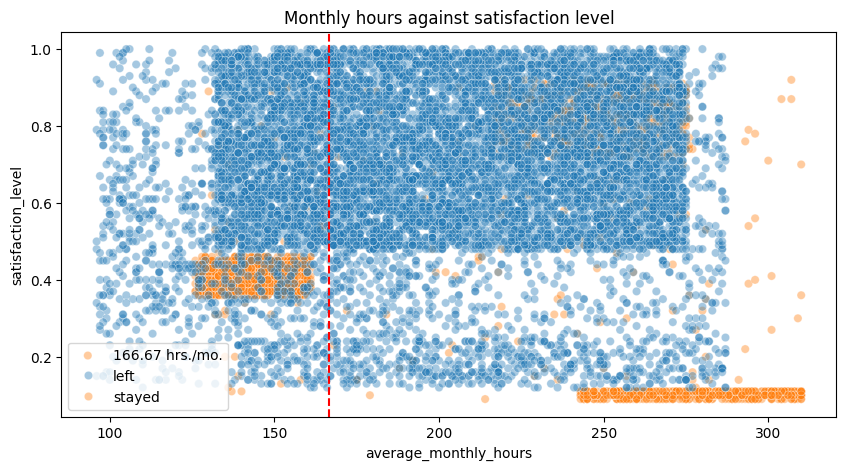

In [41]:
# Next, compare the average monthly hours worked against satisfaction levels.

plt.figure(figsize = (10, 5))
sns.scatterplot(data = df, x = "average_monthly_hours", y = "satisfaction_level", hue = "left", alpha = 0.4)
plt.axvline(x = 166.67, color = "red", ls = "--")
plt.legend(labels = ["166.67 hrs./mo.", "left", "stayed"])
plt.title("Monthly hours against satisfaction level")
plt.show()

166.67 hours is the average working time per month given a 40h work week. There is a large group of employees who worked ~240 to ~320h per month which is way higher than the standard working time. This could have resulted in low satisfaction levels (<0.2) contributing to their leaving. There is also another group of employees with normal working hours of ~125h to ~175h per month with relatively low satisfaction levels as well (~0.4). Other reasons that cannot be concluded from the data could have resulted in their leaving.

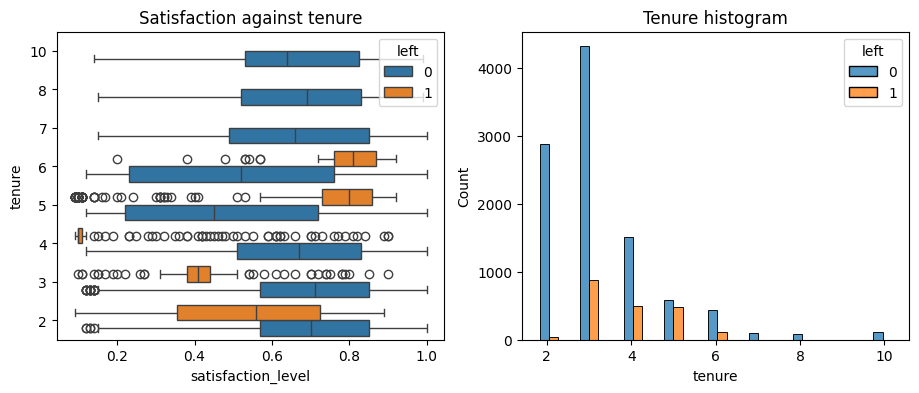

In [52]:
# Next, compare tenure and satisfaction levels.
fig, ax = plt.subplots(1, 2, figsize = (11,4))

sns.boxplot(data = df, x = "satisfaction_level", y = "tenure", hue = "left", orient = "h", ax = ax[0])
ax[0].invert_yaxis()
ax[0].set_title("Satisfaction against tenure")

sns.histplot(data = df, x = "tenure", hue = "left", multiple = "dodge", shrink = 5, ax = ax[1])
ax[1].set_title("Tenure histogram")
plt.show()

Generally, there are 2 groups of employees who left. Employees with short tenure and low satisfaction level, and employees with medium tenure length and higher satisfaction levels.
Employees with longest tenures did not leave. However, there are very few of them as seen in the histogram.

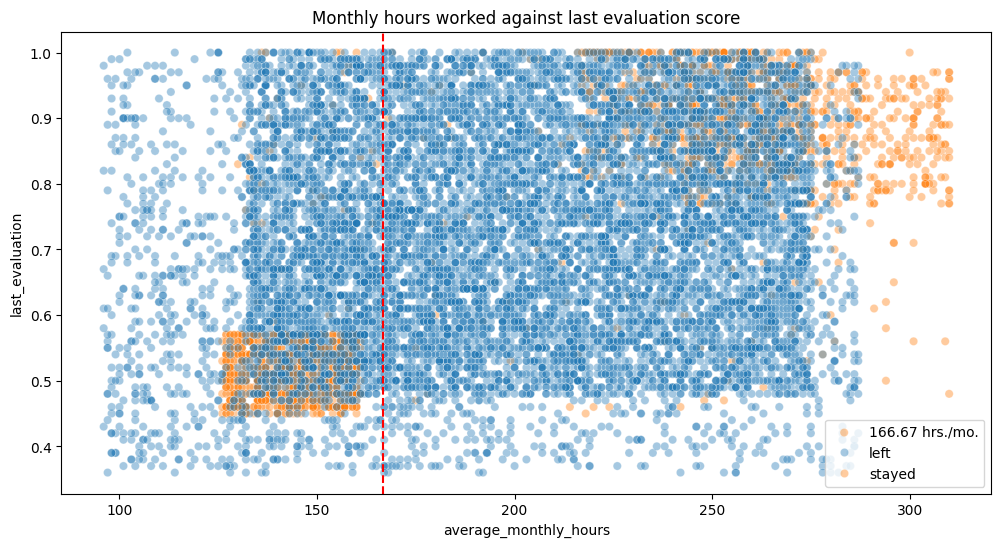

In [55]:
# Next, compare monthly hours worked and employee's last evaluation score.
plt.figure(figsize = (12, 6))
sns.scatterplot(data = df, x = "average_monthly_hours", y = "last_evaluation", hue = "left", alpha = 0.4)
plt.axvline(x = 166.67, color = "red", label = "166.67 hrs./mo.", ls = "--")
plt.legend(labels = ["166.67 hrs./mo.", "left", "stayed"])
plt.title("Monthly hours worked against last evaluation score")
plt.show()

There are 2 groups of employees who left. One where employees are overworked but with high evaluation scores. The other where employees have normal working hours, but have lower evaluation scores.

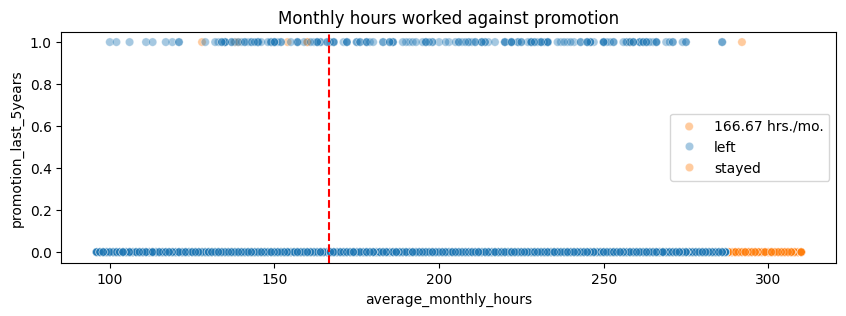

In [58]:
# Next, examine relationship between hours worked and whether employees received a promotion.
plt.figure(figsize = (10, 3))
sns.scatterplot(data = df, x = "average_monthly_hours", y = "promotion_last_5years", hue = "left", alpha = 0.4)
plt.axvline(x = 166.67, color= "red", ls="--")
plt.legend(labels = ["166.67 hrs./mo.", "left", "stayed"])
plt.title("Monthly hours worked against promotion")
plt.show()

Very few employees who were promoted in the last 5 years left the company. Large group of employees who left were overworked and did not receive a promotion in the last 5 years.

department
sales          3239
technical      2244
support        1821
IT              976
RandD           694
product_mng     686
marketing       673
accounting      621
hr              601
management      436
Name: count, dtype: int64


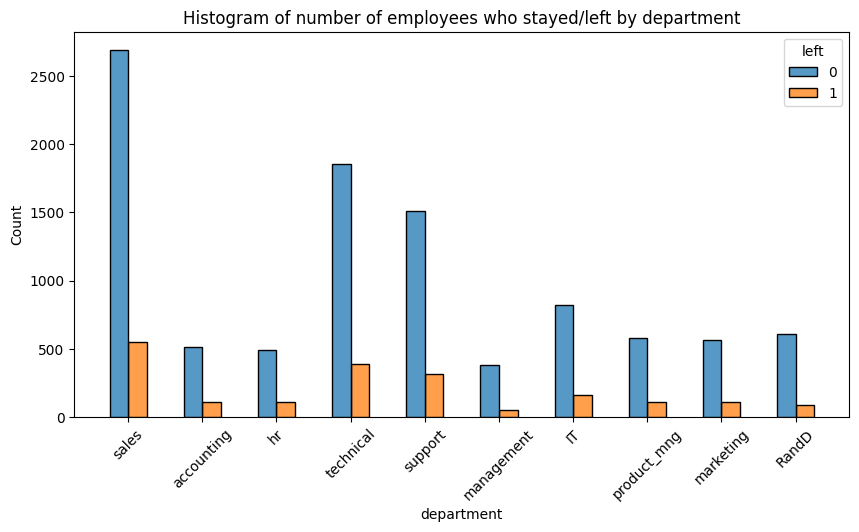

In [64]:
# Next, examine the distribution of employees who left across departments.
print(df["department"].value_counts())

plt.figure(figsize = (10, 5))
sns.histplot(data = df, x = "department", hue = "left", multiple = "dodge", shrink = 0.5)
plt.xticks(rotation = 45)
plt.title("Histogram of number of employees who stayed/left by department")
plt.show()

There are no noticeable difference in proportion of employees who stayed/left from different departments.

We can then check for correlation between variables in the dataset.

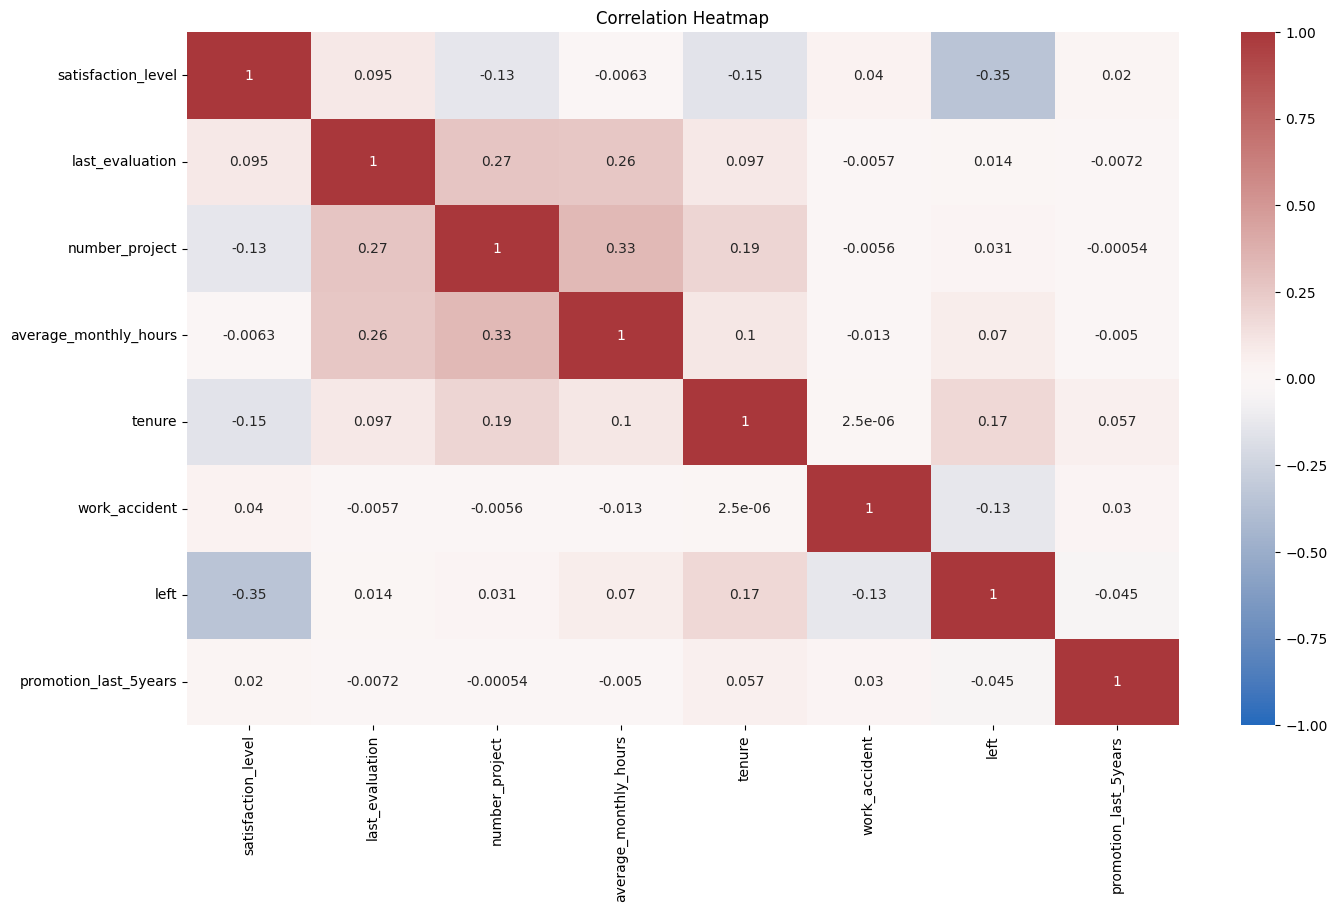

In [72]:
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df.drop(columns = ["department", "salary"]).corr(), vmin=-1, vmax=1, annot=True,
                    cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title("Correlation Heatmap")
plt.show()

There is some correlation between number of projects, monthly hours worked, and evaluation scores.

### **Creating Predictor Models**

Since we want to predict whether an employee or leave or not, which is categorical, we will use logistic regression, decision trees, and random forests and compare which model would be the best depending on the precision, recall, accuracy, and f1 score of the model.

#### Logistic Regression

In [145]:
# Encode all variables into numerical type
dflog = df.copy()
dflog["salary"] = dflog["salary"].astype("category").cat.set_categories(["low", "medium","high"]).cat.codes
dflog = pd.get_dummies(dflog, drop_first = False, dtype = int)
dflog.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


Since logistic regression is sensitive to outliers, we should remove the outliers in tenure as found above.

In [146]:
dflog1 = dflog[(dflog["tenure"]>=lower) & (dflog["tenure"]<=upper)]

In [147]:
# Carry out logistic regression
y = dflog1["left"]
x = dflog1.drop("left", axis = 1)
trainx, testx, trainy, testy = mdl.train_test_split(x, y, test_size = 0.25, stratify = y, random_state = 42)
clf = LogisticRegression(random_state = 42, max_iter = 500).fit(trainx, trainy)
predy = clf.predict(testx)

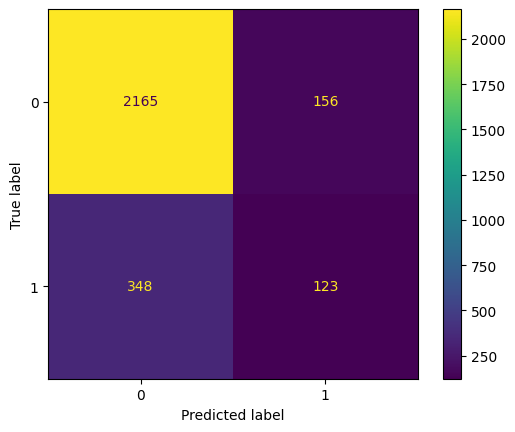

In [148]:
# Confusion matrix
cm = metrics.confusion_matrix(testy, predy, labels = clf.classes_)
disp = metrics.ConfusionMatrixDisplay(cm, display_labels = clf.classes_)
disp.plot(values_format = "")
plt.show()

There are 2165 employees who are predicted to stay and stayed. There are 123 employees who are predicted to leave who left. There are 156 employees predicted to leave, but actually stayed (false positive). There are 348 employees predicted to stay, but actually left (false negative).

In [149]:
names = ["Predicted stay", "Predicted leave"]
print(metrics.classification_report(testy, predy, target_names = names))

                 precision    recall  f1-score   support

 Predicted stay       0.86      0.93      0.90      2321
Predicted leave       0.44      0.26      0.33       471

       accuracy                           0.82      2792
      macro avg       0.65      0.60      0.61      2792
   weighted avg       0.79      0.82      0.80      2792



Logistic regression model achieved 79% precision, 82% recall, 80% f1 score, and 82% accuracy. The scores for predicting if employees will leave is significantly lower. In this case, decision trees/random forests might be more appropriate.

#### Decision Tree

In [127]:
dftree = dflog.copy()
y = dftree["left"]
x = dftree.drop("left", axis = 1)
trainx, testx, trainy, testy = mdl.train_test_split(x, y, test_size = 0.25, stratify = y, random_state = 0)
tree = DecisionTreeClassifier(random_state = 0)
para = {"max_depth":[4, 6, 8, None],
             "min_samples_leaf": [2, 5, 1],
             "min_samples_split": [2, 4, 6]
             }
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
tree1 = mdl.GridSearchCV(tree, para, scoring = scoring, cv = 4, refit = "roc_auc")

In [128]:
tree1.fit(trainx, trainy)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [129]:
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [130]:
tree1.best_score_

0.969819392792457

In [131]:
# Write a function to get the other score metrics
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
      
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [132]:
tree1cv = make_results("Decision Tree CV", tree1, "auc")
tree1cv

,model,precision,recall,F1,accuracy,auc
0,Decision Tree CV,0.914552,0.916949,0.915707,0.971978,0.969819


All scores of the decision tree model are good, and perform better than logistic regression. However, decision trees can be vulnerable to overfitting, hence we will use random forest to counter this problem.

#### Random Forest

In [133]:
rf = RandomForestClassifier(random_state = 0)
para = {'max_depth': [3,5, None], 
        'max_features': [1.0],
         'max_samples': [0.7, 1.0],
         'min_samples_leaf': [1,2,3],
         'min_samples_split': [2,3,4],
         'n_estimators': [300, 500]}  
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]
rf1 = mdl.GridSearchCV(rf, para, scoring = scoring, cv = 4, refit = "roc_auc")

In [134]:
rf1.fit(trainx, trainy)

GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [135]:
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 500}

In [136]:
rf1.best_score_

0.9804250949807172

In [137]:
rf1cv = make_results("Random Forest CV", rf1, "auc")
print(tree1cv)
print(rf1cv)

              model  precision    recall        F1  accuracy       auc
0  Decision Tree CV   0.914552  0.916949  0.915707  0.971978  0.969819
              model  precision    recall        F1  accuracy       auc
0  Random Forest CV   0.950023  0.915614  0.932467  0.977983  0.980425


The scores of random forest model are generally better than that of the decision tree model. Hence, the random forest model would be best to use for prediction.

Now we want to use this model on the test set.

In [142]:
# Function to get scores from a model's predictions.
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = metrics.roc_auc_score(y_test_data, preds)
    accuracy = metrics.accuracy_score(y_test_data, preds)
    precision = metrics.precision_score(y_test_data, preds)
    recall = metrics.recall_score(y_test_data, preds)
    f1 = metrics.f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                         })
  
    return table

In [143]:
rf1test = get_scores("Random Forest Test", rf1, testx, testy)
rf1test

,model,precision,recall,f1,accuracy,auc
0,Random Forest Test,0.964211,0.919679,0.941418,0.980987,0.956439


Since test scores are high and similar to training scores, this model is strong and will likely perform well on new datasets as well.

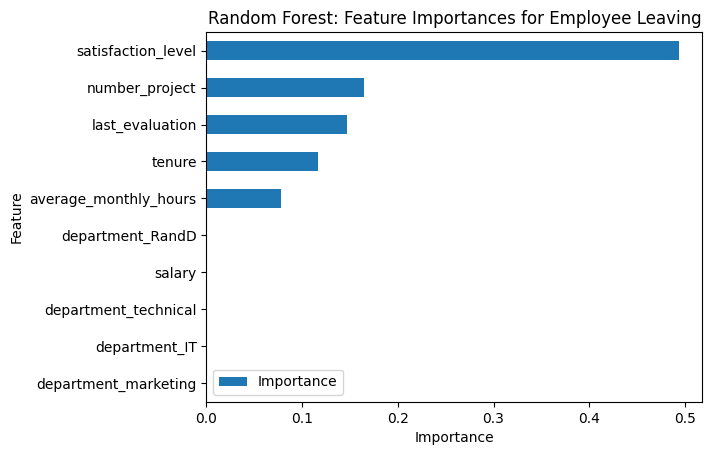

In [144]:
# Plot feature importance
features = rf1.best_estimator_.feature_importances_
ind = np.argpartition(rf1.best_estimator_.feature_importances_, -10)[-10:]
feat = x.columns[ind]
features = features[ind]

y_df = pd.DataFrame({"Feature": feat, "Importance": features})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind = 'barh', ax = ax1, x = "Feature", y = "Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving")
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

This shows that from the random forest model, `satisfaction levels`, `number of projects`, `evaluation score`, `tenure`, and `average monthly hours` worked, are the most important features to predict the outcome `left`, whether an employee will leave or not.

#### **Summary and Recommendations**

Overall, random forest outperformed the decision tree and logistic regression as it achieved higher score metrics.

The models and feature importance imply that employees being overworked is the likely reason for them leaving. In order to retain employees, we could recommend to the stakeholder to:
* Cap the number of projects given to employees.
* Promote employees who have worked at the company for a period of > 4 years.
* Refrain from letting employees work for very long hours.
* Not to reserve high evaluation scores for employees who work long hours. Could use a performance based metric to evaluate employees instead.